# Qiskit Pulse
In this notebook we will learn about the calibration of the supeconducting qubits.

## 1) Chosing the device

The only available device that supports Pulse is imbq_armonk.

In [1]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_armonk')

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

Let's get the sampling time of our backend

In [3]:
dt = backend_config.dt
print(f'Sampling time: {dt*1e9} ns')

Sampling time: 0.2222222222222222 ns


Let's get all defaults of our backend, this will keep which pulses are used to implement gates and which frequency is needed to measure or control the qubit.

In [4]:
backend_defaults = backend.defaults()

In [5]:
print(f"Measured qubit frequency: {backend_defaults.meas_freq_est[0]} Hz")
print(f"Qubit frequency: {backend_defaults.qubit_freq_est[0]} Hz")

Measured qubit frequency: 6993427855.0 Hz
Qubit frequency: 4974443060.987246 Hz


## 2) Searching for the qubit Frequency

The first thing we should do is to find the qubit frequency, which is the frequency needed excite the ground state of the qubit.

In order to find this, we should do a sweep on the range of frequencies and see if there is an absorbtion on the spectrum. 

It is important to note that this sweep can be broad, in order to make it easier we can use the calibration frequency provided by IBM.

In [52]:
import numpy as np 

# Conversion factors 
GHz = 1.e9
MHz = 1.e6
kHz = 1.e3
us = 1.e-6
ns = 1.e-9

# Choosing the qubit that we want to analyse
qubit = 0

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]

print(f'Qubit {qubit} has an estimated frequency of {center_frequency_Hz/GHz} GHz\n')

scale_factor = 1e-14

# We will span 40 MHz around the estimated frequency
# with steps of 1 MHz
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 1 * MHz

frequency_max = center_frequency_Hz + frequency_span_Hz/2
frequency_min = center_frequency_Hz - frequency_span_Hz/2

frequencies_GHz = np.arange(frequency_min / GHz, frequency_max / GHz, frequency_step_Hz / GHz)

print(f'The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz in steps of {frequency_step_Hz / MHz} MHz')

Qubit 0 has an estimated frequency of 4.974443060987245 GHz

The sweep will go from 4.954443060987246 GHz to 4.994443060987246 GHz in steps of 1.0 MHz


After getting the frequencies needed, we need to define the pulses for the experiment. In order to control the qubit, we need to use a driver pulse that in this case we will use a gaussian pulse.

We need to make the pulse duration in terms of the sampling time of the device, due to technical problems all samples needs to be a multiple of 16, thus we use a helper function to fund the closest multiple of 16 in order to satisfy this technical constraint.

In [7]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) %16)

In [8]:
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib

# Driver pulse parameters in microseconds
drive_sigma_us = 0.075
drive_samples_us = drive_sigma_us*8

# Width of the gaussian in units of sample time
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us / dt)
drive_samples = get_closest_multiple_of_16(drive_samples_us * us / dt)
drive_amp = 0.3

# Create drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                        sigma=drive_sigma,
                        amp=drive_amp,
                        name='freq_sweep_excitation_pulse')


Due to the hardware constraint when we measure a qubit it is needed to measure all qubits, thus we have to respect this constraint when we are building programs in pulse. Let's check which group of qubits our qubit is in:

In [9]:
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the measurement map!"

Now that we know the in which measurement map our qubit is, we can create a measurement pulse. It is better to use the calibration pulse provided by IBM on the backend configuration, this can be used without a problem because it is frequently calibrated and also comes with the acquisition.

In [10]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

Lastly, we specify the drive, measurement and acquisition channels.

In [11]:
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Now we can finally create our pulse schedules. At each frequency, we send a drive pulse of that frequency and measure it immeaditely after the pulse. 

The scheduled frequencies are kept in a dictionary indexed by the driver channel.

In [12]:
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)

# << is used to shift the start time of the schedule by some time
# Thus in this case, we are putting the measurement after the schedule duration
schedule += measure << schedule.duration

frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

Let's see what is our pulse schedule:

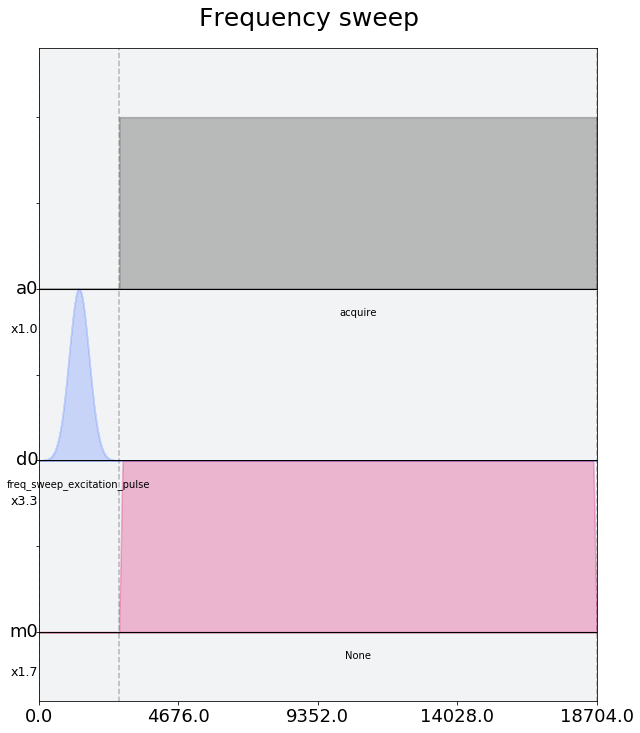

In [13]:
schedule.draw(label=True)

In order to assemble our schedule we create a program object that is called Qobj, this is the standard used by IBM in order to send to quantum devices. We request that we repeat each schedule by a number of shots in order to estimate get a good statistical estimate of our qubit response.

You can choose which level you want for the measurement: 

 - `meas_leavel=0` returns raw values, that is an array of complex values per shot.
 - `meas_level=1` returns a kerneled value, that is single complex value per shot.
 - `meas_level=2` returns classified data: 0 or 1 bit for each shot.

You can choose if the measurement return is the information of every single shot or the average of all shots, by using 'avg' or 'single' in `meas_return`


In [14]:
from qiskit import assemble

num_shots_per_frequency = 2048
frequency_sweep_program = assemble(schedule,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

Now we can run the program on a quantum computer:

In [15]:
from qiskit.tools.monitor import job_monitor
run_on_device = False
if run_on_device:
    job = backend.run(frequency_sweep_program)
    job_monitor(job)
    print("ID:",job.job_id())
    # Retrieving the results
    try:
        frequency_sweep_results = job.result(timeout=120)
    except:
        job.error_message()

In [16]:
# Retrieving an older job
retrieve_job = '5f501a8aa1b666001a2d4328'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    frequency_sweep_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


Let's plot our frequency sweep:

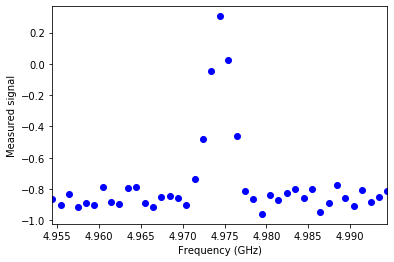

In [17]:
import matplotlib.pyplot as plt

sweep_values = []
for index in range(len(frequency_sweep_results.results)):
    res = frequency_sweep_results.get_memory(index) * scale_factor
    sweep_values.append(res[qubit])

plt.plot(frequencies_GHz, np.real(sweep_values), 'bo')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Measured signal")
plt.show()

There is a peak on our frequency sweep! This now we can find the qubit frequency by fitting a lorentzian on our plot, a lorentzian is of the form:

$$
f(x) = A \frac{B}{(x - q_{\mathrm{freq}})^2 + B^2} + C
$$

In [18]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)    
    return fitparams, y_fit

def lorentzian(x, A, q_freq, B, C):    
    return (A ) * B / ((x - q_freq)**2 + B**2) + C



In [19]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values),                                
                                 lorentzian,
                                 [5, 4.97, 1, 3])

Let's see the lorentzian fit

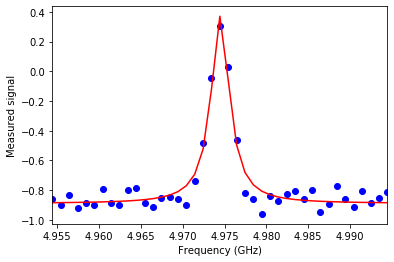

In [20]:
plt.plot(frequencies_GHz, np.real(sweep_values), 'bo')
plt.plot(frequencies_GHz, y_fit, 'r')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Measured signal")
plt.show()

In [21]:
_, estimated_qubit_frequency, *_ = fit_params
estimated_qubit_frequency *= GHz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(estimated_qubit_frequency / GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97444 GHz to 4.9745 GHz.


# 3) Rabi Experiment

In the Rabi experiment we want to determine which pulse is needed to construct a X rotation on the bloch sphere. Assuming that our qubit is perfect, we have the following drive hamiltonian that controlls the qubit:

$$
H_{\mathrm{eff}} = - \frac{1}{2} \hbar \Delta_q \sigma^Z - \hbar \Omega \sigma^X
$$

Where: $\Omega = \vec{d}_0 \cdot \vec{E}_0$, $\vec{d} = \vec{d}_0 \sigma^ + \vec{d}_0^* \sigma^-$ is the Transmon's dipole and the electric field applied for controlling the qubit is: $\vec{E}(t) = \vec{E}_0 e^{-i \omega_d t} + \vec{E}_0 e^{i \omega_d t}$. 

Thus in this experiment we want to change the electric field applied in order to be in resonance $\Delta_q = 0$, when this happens we have a X rotation on the bloch sphere and we sucessfully changed our qubit by an X gate $| 0 \rangle \rightarrow | 1 \rangle$, or vice versa. 

We will use the qubit frequency estimated on the previous experiment.

In [22]:
num_rabi_points = 50

# Defining the drive amplitudes
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In order to create a rabi experiment, we need to send a gaussian pulse just as before and vary the amplitude of the pulse.

In [23]:
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp,
    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    
    this_schedule += Play(rabi_pulse, drive_chan)

    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

Let's see what the schedule looks like

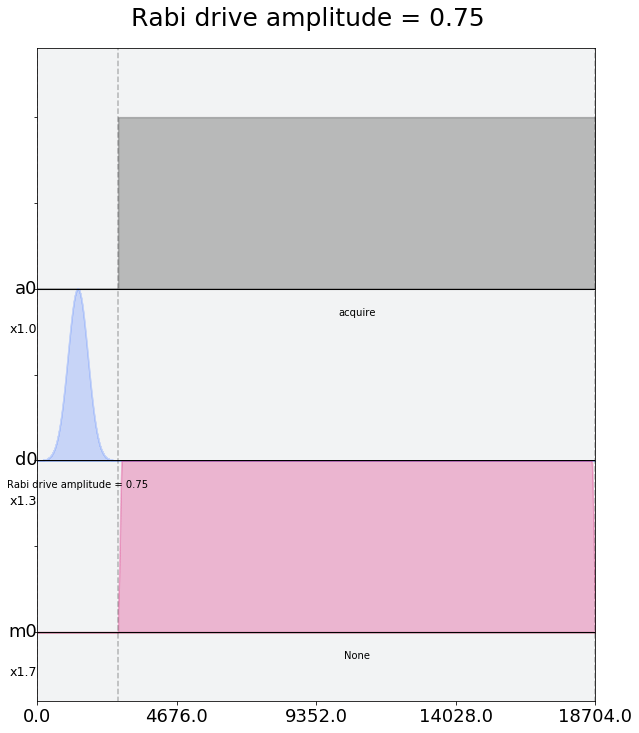

In [24]:
rabi_schedules[-1].draw(label=True)

Now let's assemble our schedule and run on the hardware

In [25]:
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: estimated_qubit_frequency}]* num_rabi_points)

In [26]:
run_on_device = False
if run_on_device:
    job = backend.run(rabi_experiment_program)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    rabi_results = job.result(timeout=120)

In [27]:
# Retrieving an older job
retrieve_job = '5f53ebefc06d9800196381e6'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    rabi_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


In [28]:
rabi_values = []
for i in range(num_rabi_points):
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(np.array(rabi_values) - np.mean(rabi_values))

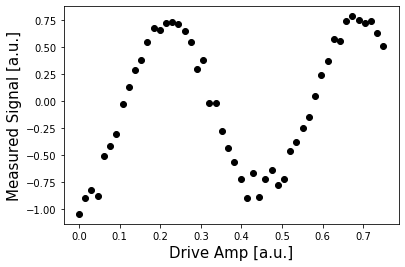

In [29]:
plt.xlabel("Drive Amp [a.u.]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.plot(drive_amps, rabi_values, 'o', color='black')
plt.show()

In [30]:
def cos_fit(x, A, B, period, phi):
    return A * np.cos(2*np.pi*x/period - phi) + B
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values,
                                 cos_fit,
                                 [3, 0.1, 0.5, 0])

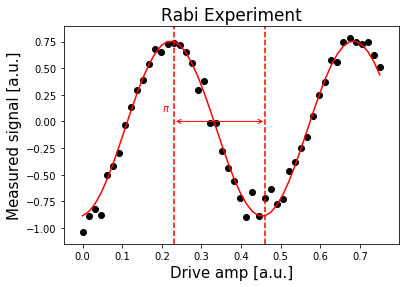

In [31]:
plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title("Rabi Experiment", fontsize=17)
plt.show()

Now we can find the X pulse, which is half of the period.

In [32]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.2304683461290338


In [49]:
# Create a pi pulse
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi pulse')

# 4) Separating $| 0 \rangle$ and $| 1 \rangle$

Now that we have our way to tranform the $| 0 \rangle$ to $| 1 \rangle$, we can calibrate the output data to differentiate between $| 0 \rangle$ and $| 1 \rangle$ states. This is done by sampling a number of data and clustering them into classes.

In [34]:
# Ground State Schedule
ground_schedule = pulse.Schedule(name='ground state')
ground_schedule += measure

# Excited State Schedule
excited_schedule = pulse.Schedule(name='excited state')
excited_schedule += Play(pi_pulse, drive_chan)
excited_schedule += measure << excited_schedule.duration

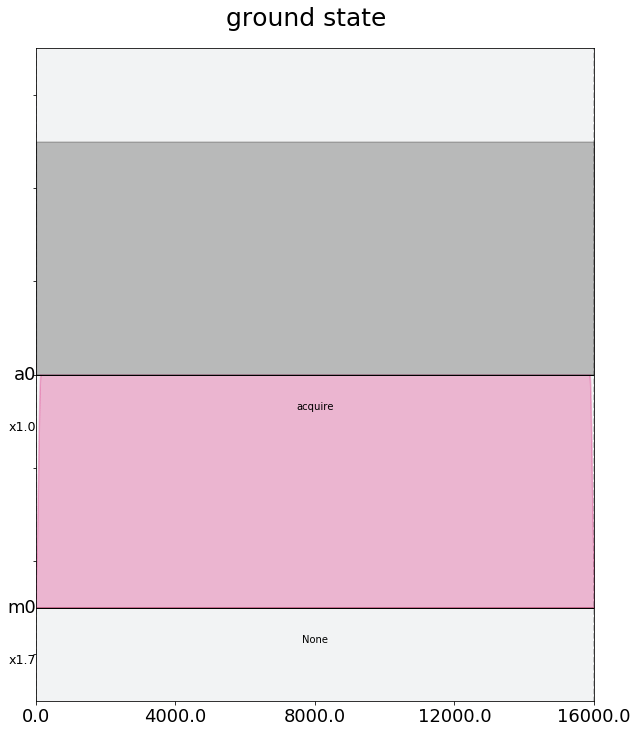

In [35]:
ground_schedule.draw(label=True)

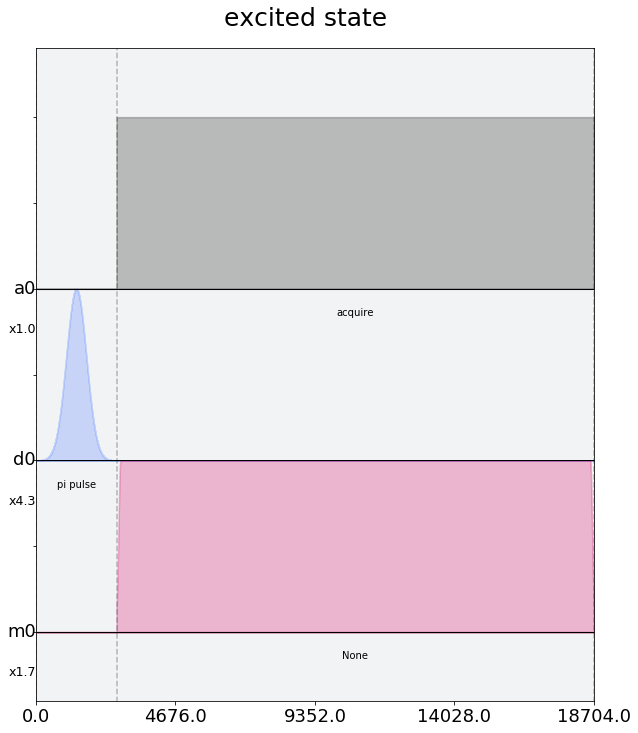

In [36]:
excited_schedule.draw(label=True)

Let's assemble both schedules in a quantum object and run getting the kernel results `meas_level=1`, because we do not want them already classified into 0 and 1's.

In [37]:
num_shots = 1024

discriminator_schedule = assemble([ground_schedule, excited_schedule],
                                  backend=backend,
                                  meas_level=1,
                                  meas_return='single',
                                  shots=num_shots,
                                  schedule_los=[{drive_chan: estimated_qubit_frequency}]*2)

In [38]:
run_on_device = False
if run_on_device:
    job = backend.run(discriminator_schedule)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    descriminator_results = job.result(timeout=120)

In [39]:
# Retrieving an older job
retrieve_job = '5f54025607e9fa001aba6439'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    discriminator_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


In [40]:
ground_results = discriminator_results.get_memory(0)[:, qubit]*scale_factor
excited_results = discriminator_results.get_memory(1)[:, qubit]*scale_factor

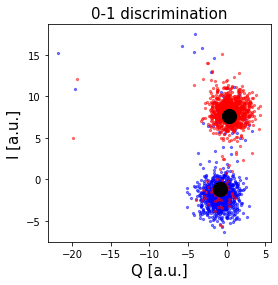

In [41]:
plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(ground_results), np.imag(ground_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(excited_results), np.imag(excited_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(ground_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(excited_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

We can see clearly 2 clusters, for the `meas_level=2` it is used a Linear Discriminator to discriminate between both classes.

# 5) Measuring $T_1$

Now, we want to measure the time that takes for a qubit to decay from the excited state to the ground state. This is done by applying a $\pi$ pulse and add a delay before measuring the qubit.

In [42]:
# Experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)

# Convert to units of dt
delay_times_dt = times_us * us / dt

In [43]:
# Creating schedules
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt / us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

Let's check two examples to see how the delay increases.

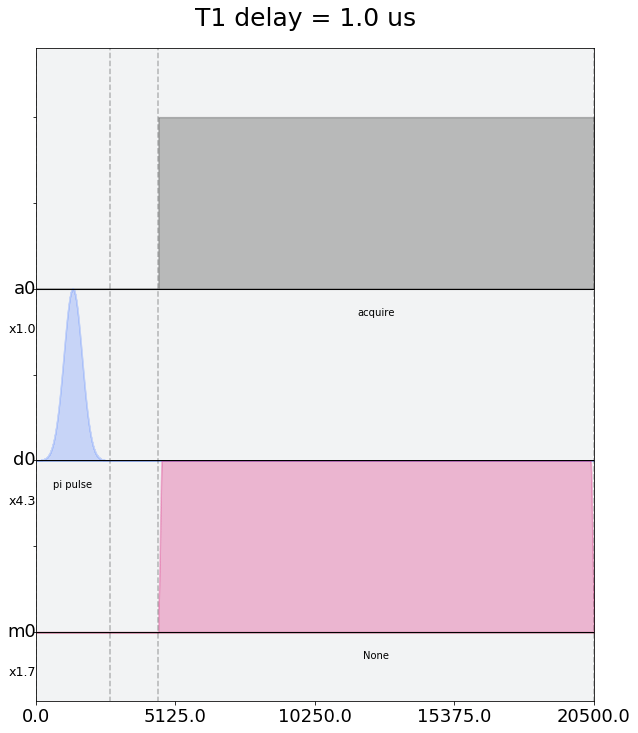

In [44]:
t1_schedules[0].draw(label=True)

Let's assemble and run on the device.

In [45]:
num_shots = 1024

t1_experiment = assemble(t1_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: estimated_qubit_frequency}] * len(t1_schedules))

In [46]:
run_on_device = False
if run_on_device:
    job = backend.run(t1_experiment)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    t1_results = job.result(timeout=120)

In [47]:
# Retrieving an older job
retrieve_job = '5f5b5ae704d0cb001aca1ec3'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    t1_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


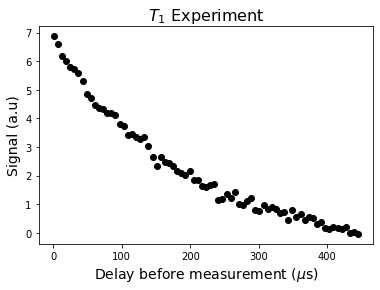

In [50]:
t1_values = []

for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)

t1_values = np.real(t1_values)

plt.plot(times_us, t1_values, 'o', color='black')
plt.title("$T_1$ Experiment", fontsize=16)
plt.xlabel("Delay before measurement ($\mu$s)", fontsize=14)
plt.ylabel("Signal (a.u)", fontsize=14)
plt.show()

This is a exponential decay given by the following formula:

$$
f(x) = A e^{-x/T_1} + C
$$

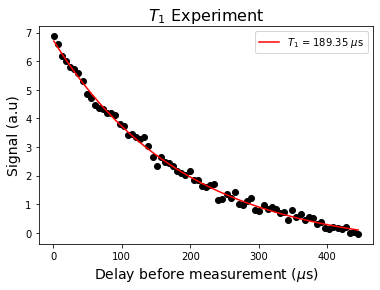

In [51]:
def exp_decay(x, A, T1, C):
    return A* np.exp(- x / T1) + C

fit_params, y_fit = fit_function(times_us, t1_values, exp_decay, [-3, 3, 100])

*_, T1, _ = fit_params

plt.plot(times_us, t1_values, 'o', color='black')
plt.plot(times_us, y_fit, 'r', label=f"$T_1$ = {T1:.2f} $\mu$s")
plt.title("$T_1$ Experiment", fontsize=16)
plt.xlabel("Delay before measurement ($\mu$s)", fontsize=14)
plt.ylabel("Signal (a.u)", fontsize=14)
plt.legend()
plt.show()

# 6) Ramsey Experiment

Now that we have defined the $\pi$ pulse, we can determine the qubit frequency with better precision, this is done by a Ramsey experiment. This experiment consists of applying a $\frac{\pi}{2}$ pulse, then adding a delay and applying a $\frac{\pi}{2}$ pulse again. Since we are measuring the signal from the qubit at the same frequency, we should observe oscillations at the difference in frequency between the applied pulse and the qubit.

In [63]:
# Parameters
time_max_us = 1.8
time_min_us = 0.1
time_step_us = 0.025
times_us = np.arange(time_min_us, time_max_us, time_step_us)

# Converting to units of dt
delay_times_dt = times_us * us / dt

# Drive parameters
drive_amp = pi_amp / 2
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=drive_amp,
                               sigma=drive_sigma,
                               name='x90_pulse')

In [64]:
ramsey_schedules = []

for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)

Let's see the schedule of a Ramsey Experiment:

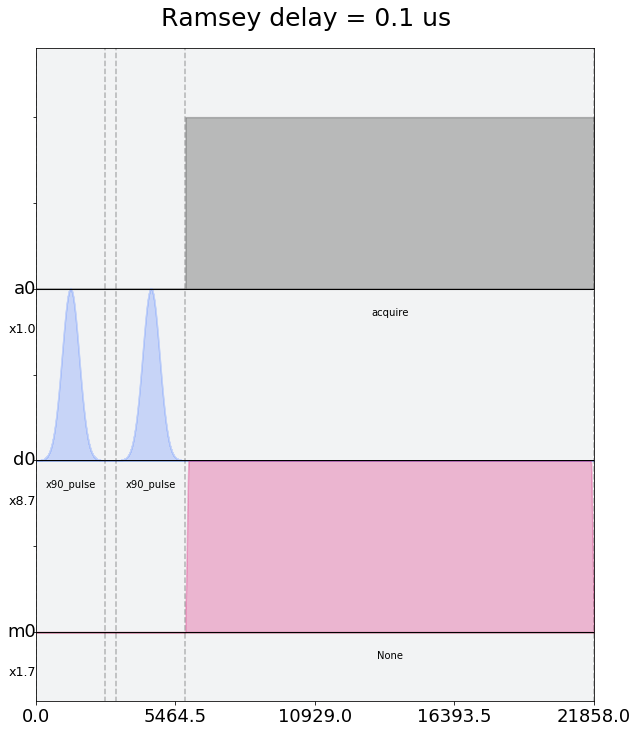

In [65]:
ramsey_schedules[0].draw(label=True)

Now let's apply a trick, we will drive the pulses slightly off-resonance. This will show oscillations with frequency near the detuning MHz, with a small offset, this offset is exactly how far away our previous estimation was from the qubit frequency.

In [66]:
num_shots = 1024

detuning_MHz = 2
ramsey_frequency = round(estimated_qubit_frequency + detuning_MHz * MHz, 6)
ramsey_program = assemble(ramsey_schedules,
                          backend=backend,
                          meas_level=1,
                          meas_return='avg',
                          shots=num_shots,
                          schedule_los=[{drive_chan:ramsey_frequency}]*len(ramsey_schedules))

In [67]:
run_on_device = False
if run_on_device:
    job = backend.run(ramsey_program)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    ramsey_results = job.result(timeout=120)

In [68]:
# Retrieving an older job
retrieve_job = '5f5b5fe8d7b9b100190ee7b5'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    ramsey_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


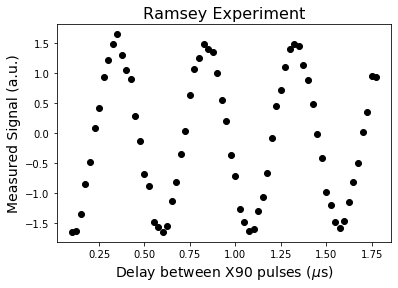

In [69]:
ramsey_values = []

for i in range(len(times_us)):
    ramsey_values.append(ramsey_results.get_memory(i)[qubit]*scale_factor)

plt.plot(times_us, np.real(ramsey_values), 'o', color='black')
plt.title("Ramsey Experiment", fontsize=16)
plt.xlabel("Delay between X90 pulses ($\mu$s)", fontsize=14)
plt.ylabel("Measured Signal (a.u.)", fontsize=14)
plt.show()

Now let's fit the sinuisoid and extract the value that our qubit is offset from the qubit frequency.

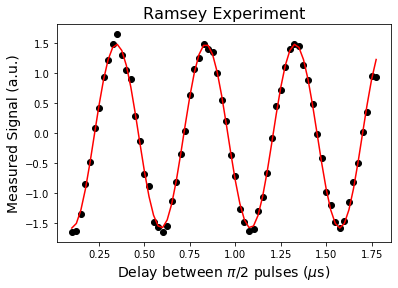

In [70]:
def sin_fit(x, A, f_MHz, C, B):
    return A * np.cos(2*np.pi*f_MHz*x - C) + B

fit_params, y_fit = fit_function(times_us, np.real(ramsey_values), sin_fit, [5, 1./.4, 0, 0.25])

_, del_f_MHz, *_ = fit_params

plt.plot(times_us, np.real(ramsey_values), 'o', color='black')
plt.plot(times_us, y_fit, 'r', label=f"$\Delta$f = {del_f_MHz:.2f} MHz")
plt.title("Ramsey Experiment", fontsize=16)
plt.xlabel("Delay between $\pi/2$ pulses ($\mu$s)", fontsize=14)
plt.ylabel("Measured Signal (a.u.)", fontsize=14)
plt.show()

Now that we know the offset we can update our qubit frequency.

In [71]:
new_qubit_freq = estimated_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz

print(f"Our updated qubit frequency is now {round(new_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(estimated_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.974533 GHz. It used to be 4.974499 GHz


# 7) Measuring $T_2$

For measuring the coherence time, we will do a experiment that is called Hahn Echo. This experiment consists of a $\frac{\pi}{2}$ pulse + $\tau$ delay + $\pi$ pulse + $\tau$ delay + $\frac{\pi}{2}$ pulse. The decay time for the Hahn Echo experiment gives us $T_2$.

In [72]:
tau_max_us = 200
tau_min_us = 2
tau_step_us = 4
taus_us = np.arange(tau_min_us, tau_max_us, tau_step_us)

# Convert to units of dt
delay_times_dt = taus_us * us / dt

In [73]:
t2_schedules = []
for tau in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T2 delay = {tau * dt/us}")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= measure << int(this_schedule.duration)

    t2_schedules.append(this_schedule)

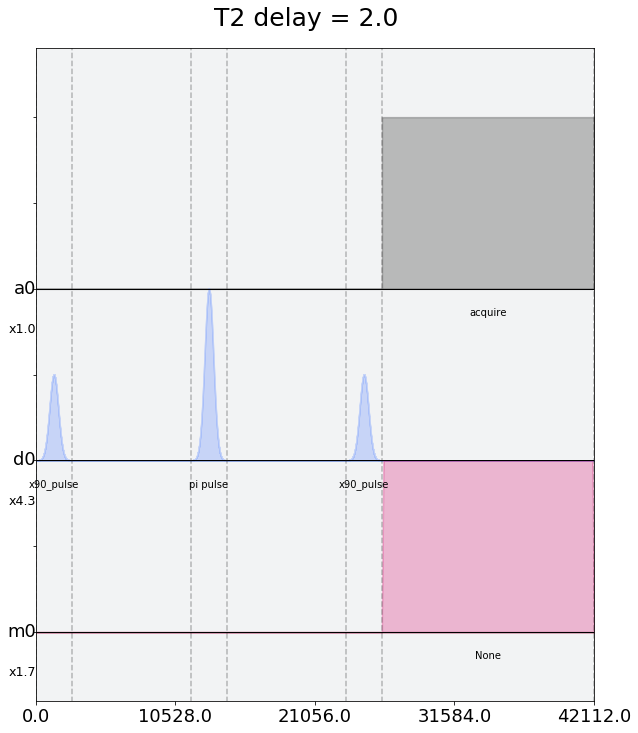

In [74]:
t2_schedules[0].draw(label=True)

In [75]:
num_shots = 1024

t2_experiment = assemble(t2_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                        schedule_los=[{drive_chan: new_qubit_freq}]*len(t2_schedules))

In [76]:
run_on_device = False
if run_on_device:
    job = backend.run(t2_experiment)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    t2_results = job.result(timeout=120)

In [77]:
# Retrieving an older job
retrieve_job = '5f5b67fc27ef38001a40033f'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    t2_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


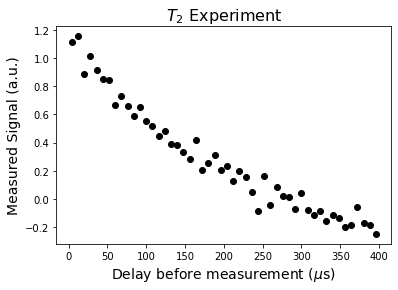

In [78]:
t2_values = []

for i in range(len(delay_times_dt)):
    t2_values.append(t2_results.get_memory(i)[qubit]*scale_factor)
    
plt.plot(2*taus_us, np.real(t2_values), 'o', color='black')
plt.xlabel("Delay before measurement ($\mu$s)", fontsize=14)
plt.ylabel('Measured Signal (a.u.)', fontsize=14)
plt.title('$T_2$ Experiment', fontsize=16)
plt.show()

Let's fit an exponential decay just like $T_1$

/home/nahum/anaconda3/envs/qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


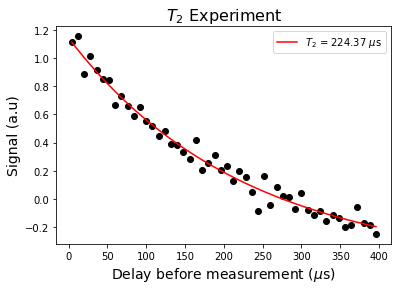

In [79]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),exp_decay, [-3, 1, 100])

*_, T2, _ = fit_params

plt.plot(2*taus_us, t2_values, 'o', color='black')
plt.plot(2*taus_us, y_fit, 'r', label=f"$T_2$ = {T2:.2f} $\mu$s")
plt.title("$T_2$ Experiment", fontsize=16)
plt.xlabel("Delay before measurement ($\mu$s)", fontsize=14)
plt.ylabel("Signal (a.u)", fontsize=14)
plt.legend()
plt.show()

# 8) Dynamical Decoupling

Dynamical Decoupling is a technique that is used to supress decoherence, in our case, we apply several $\pi$ pulses to get rid of quasi-static noise.

In [125]:
# DD experiment
tau_us_min = 1
tau_us_max = 40
tau_step_us = 1.5
taus_us = np.arange(tau_us_min, tau_us_max, tau_step_us)

# Convert to units of dt
taus_dt = taus_us * us / dt
num_pi_pulses = 4
print(f"Total time ranges from {2.*num_pi_pulses*taus_us[0]} to {2.*num_pi_pulses*taus_us[-1]} us")

Total time ranges from 8.0 to 308.0 us


In [126]:
T2DD_schedules = []

for delay in taus_dt:
    this_schedule = pulse.Schedule(name=f"T2DD delay = {delay * dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + delay)
    
    for _ in range(num_pi_pulses - 1):
        this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + 2*delay)
    
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)
    
    T2DD_schedules.append(this_schedule)

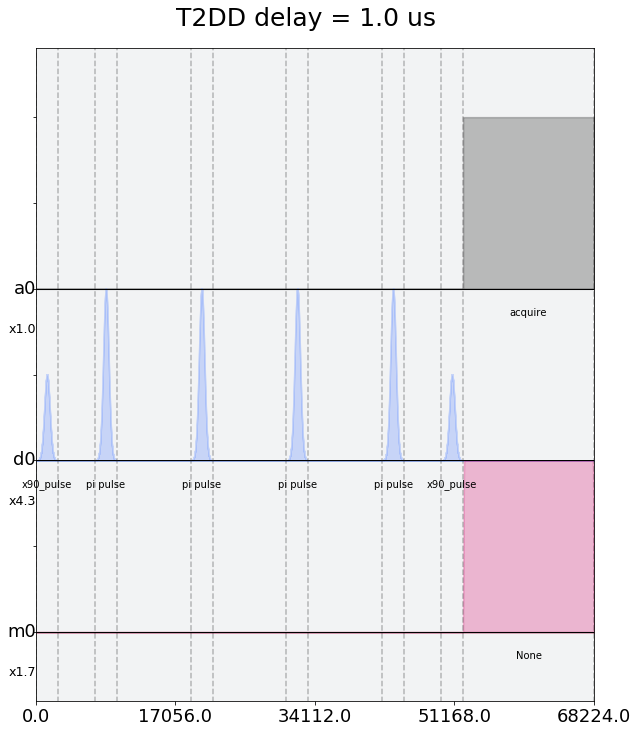

In [127]:
T2DD_schedules[0].draw(label=True)

In [128]:
num_shots = 1024

T2DD_experiment = assemble(T2DD_schedules,
                            backend=backend,
                            meas_level=1,
                            meas_return='avg',
                            shots=num_shots,
                            schedule_los=[{drive_chan: new_qubit_freq}]*len(T2DD_schedules))

In [129]:
run_on_device = False
if run_on_device:
    job = backend.run(T2DD_experiment)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print(job.job_id())
    t2dd_results = job.result(timeout=120)

Job Status: job has successfully run
5f6fa50eca75d7001b29ec47


In [85]:
# Retrieving an older job
retrieve_job = '5f6fa50eca75d7001b29ec47'
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job)
    t2dd_results = job.result(timeout=120)
    print("Retrieved!")

Retrieved!


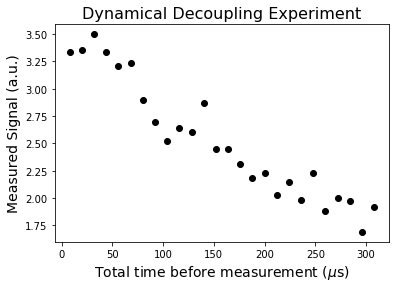

In [133]:
times_us = 2.*num_pi_pulses*taus_us

t2dd_values = []

for i in range(len(taus_us)):
    t2dd_values.append(t2dd_results.get_memory(i)[qubit]*scale_factor)

plt.plot(times_us, np.abs(np.real(t2dd_values)), 'o', color='black')
plt.xlabel("Total time before measurement ($\mu$s)", fontsize=14)
plt.ylabel('Measured Signal (a.u.)', fontsize=14)
plt.title('Dynamical Decoupling Experiment', fontsize=16)
plt.show()

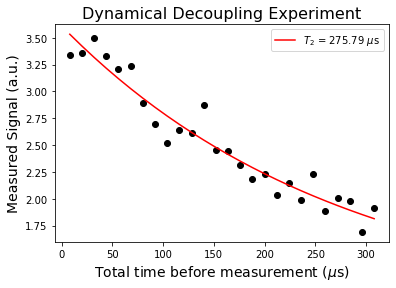

In [134]:
fit_params, y_fit = fit_function(times_us, np.abs(np.real(t2dd_values)), exp_decay, [-3, 1, 100])

*_, T2, _ = fit_params

plt.plot(times_us, np.abs(np.real(t2dd_values)), 'o', color='black')
plt.plot(times_us, y_fit, 'r', label=f"$T_2$ = {T2:.2f} $\mu$s")
plt.xlabel("Total time before measurement ($\mu$s)", fontsize=14)
plt.ylabel('Measured Signal (a.u.)', fontsize=14)
plt.title('Dynamical Decoupling Experiment', fontsize=16)
plt.legend()
plt.show()

# 9) Readout Spectroscopy

The James-Cummings Hamiltonian after the Schriffer-Wolff transformation in the dispersive limit is given by:
$$
H_{\rm eff} = \left(\omega_r + \frac{g^2}{\Delta}\sigma_z\right)a^\dagger a  - \frac{1}{2}\left(\omega_q -\frac{g^2}{\Delta}\right) \sigma_z
$$
which shows a state-dependent shift by $\chi \equiv g^2/\Delta$ of the resonator frequency called the *ac Stark shift* and a shift in qubit frequency due to quantum vacuum fluctuations called the *Lamb shift*. We can get this shift using the Armonk chip.

In [66]:
# let's get the x pulse schedule
x_pulse = inst_sched_map.get('x', qubits=[qubit])

In [68]:
# Schedule for 0 state
schedule_0 = pulse.Schedule(name='0')
schedule_0 += measure

# Schedule for 1 state
schedule_1 = pulse.Schedule(name='1')
schedule_1 += x_pulse
schedule_1 += measure << schedule_1.duration

In order to see this shift, we need to make a frequency sweep, just as when we were finding out the frequency to excite our state, but in this case, we are searching the resonator frequency associated with each state on the qubit.

In [53]:
frequency_span_Hz = 320 * kHz
frequency_step_Hz = 8 * kHz

center_frequency_Hz = backend_defaults.meas_freq_est[qubit]
print(f"Qubit {qubit} has an estimated readout frequency of {center_frequency_Hz / GHz} GHz.")
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz\
      in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated readout frequency of 6.993427855 GHz.
The sweep will go from 6.993267855 GHz to 6.993587855 GHz      in steps of 0.008 MHz.


In [73]:
num_shots = 1024

frequencies_Hz = frequencies_GHz*GHz
schedule_los = [{meas_chan: freq} for freq in frequencies_Hz]

cavity_sweep_0 = assemble([schedule_0]*len(schedule_los),
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots,
                               schedule_los=schedule_los)

cavity_sweep_1 = assemble(schedule_1,
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots,
                               schedule_los=schedule_los)

In [ ]:
run_on_device = True
if run_on_device:
    
    # Job for 0 state
    job = backend.run(cavity_sweep_0)
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)
    print("Job ID 0:", job.job_id())
    cavity_sweep_0_results = job.result(timeout=120)
    
#     # Job for 1 state
#     job = backend.run(cavity_sweep_1)
#     job_monitor(job)
#     print("Job ID 1:",job.job_id())
#     cavity_sweep_1_results = job.result(timeout=120)

In [41]:
# Retrieving an older job
retrieve_job = None #['','']
if retrieve_job:    
    job = backend.retrieve_job(retrieve_job[0])
    cavity_sweep_0_results = job.result(timeout=120)
    job = backend.retrieve_job(retrieve_job[1])
    cavity_sweep_1_results = job.result(timeout=120)
print("Retrieved!")

Retrieved!


In [ ]:
scale_factor = 1e-14

sweep_values_0 = []
for i in range(len(cavity_sweep_0_results.results)):
    res_0 = cavity_sweep_0_results.get_memory(i)*scale_factor
    sweep_values_0.append(res_0[qubit])

sweep_values_1 = []
for i in range(len(cavity_sweep_1_results.results)):
    res_1 = cavity_sweep_1_results.get_memory(i)*scale_factor
    sweep_values_1.append(res_1[qubit])
    
plotx = frequencies_Hz / kHz
ploty_0 = np.abs(sweep_values_0)
ploty_1 = np.abs(sweep_values_1)

<img src="Figures/Readout_freq.png" alt="Drawing" style="width: 600px;"/>

# References

This notebook is totally based on the [qiskit textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)